# FULL model
* define function to freeze layer
* training function

In [1]:
import time
import sys
from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
from util.visualizer import Visualizer
from util.metrics import PSNR, SSIM

## Import dataloader and show it

In [2]:
sys.argv = ['test.py', '--dataroot', '/scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/',
            '--learn_residual', '--resize_or_crop', 'scale_width','--fineSize', '256']

opt = TrainOptions().parse()

['test.py', '--dataroot', '/scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/', '--learn_residual', '--resize_or_crop', 'scale_width', '--fineSize', '256']
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: /scratch/user/jiangziyu/data/GOPRO_for_reblurGAN/
dataset_mode: aligned
display_freq: 100
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 256
epoch_count: 1
fineSize: 256
gan_type: wgan-gp
gpu_ids: [0]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 100.0
lambda_B: 10.0
learn_residual: True
loadSizeX: 640
loadSizeY: 360
lr: 0.0001
max_dataset_size: inf
model: content_gan
nThreads: 2
n_layers_D: 3
name: experiment_name
ndf: 64
ngf: 64
niter: 150
niter_decay: 150
no_dropout: False
no_flip: False
no_html: False
norm: instance
output_nc: 3
phase: 
pool_size: 50
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
which_direction: A

(256, 256, 3)
(256, 256, 3)


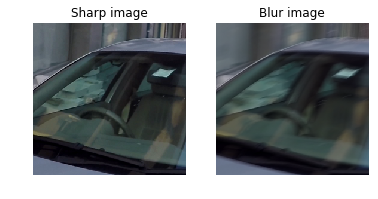

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from data.aligned_dataset import AlignedDataset

dataset = AlignedDataset()
dataset.initialize(opt)

sample = dataset[80]
fig = plt.figure()

image = ((sample['A'].numpy()+1)/2).transpose((1, 2, 0))
ax = plt.subplot(1, 2, 1)
print(image.shape)

ax.set_title('Sharp image')
ax.axis('off')
plt.imshow(image)

image = ((sample['B'].numpy()+1)/2).transpose((1, 2, 0))
ax = plt.subplot(1, 2, 2)
print(image.shape)

ax.set_title('Blur image')
ax.axis('off')
plt.imshow(image)


In [4]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()

CustomDatasetDataLoader
dataset [AlignedDataset] was created


## define model and load pretrained weights

In [5]:
import os
import torch
from torch.autograd import Variable
from collections import OrderedDict
from models import networks

def load_network(network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(opt.checkpoints_dir, opt.name, save_filename)
        network.load_state_dict(torch.load(save_path))
def save_network(network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(opt.checkpoints_dir, opt.name, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if torch.cuda.is_available():
            network.cuda()

netG_deblur = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf,
                                      opt.which_model_netG, opt.norm, not opt.no_dropout, opt.gpu_ids, False,
                                      opt.learn_residual)
netG_blur = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf,
                                      opt.which_model_netG, opt.norm, not opt.no_dropout, opt.gpu_ids, False,
                                      opt.learn_residual)

load_network(netG_deblur, 'deblur_G', opt.which_epoch)
load_network(netG_blur, 'blur_G', opt.which_epoch)
print('------- Networks deblur_G initialized ---------')
networks.print_network(netG_deblur)
print('-----------------------------------------------')

------- Networks deblur_G initialized ---------
DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
      (3): ReLU(inplace)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
      (6): ReLU(inplace)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
      (9): ReLU(inplace)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
          (3): ReLU(inplace)
          (4): Dropout(p=0.5)
          (5): ReflectionPad2d((1, 1, 

### Freeze layers

In [6]:
def fine_tune_existing_layers(model,num_layers_frozen=19):

    ct=0
    for child in list(list(netG_deblur.children())[0].children())[0]:
        ct+=1
        if ct<num_layers_frozen:
            for param in child.parameters():
                param.requires_grad=False


    print("Total number of layers are:",ct,",number of layers frozen are:", num_layers_frozen)
    return model

netG_frozen_deblur= fine_tune_existing_layers(netG_deblur, num_layers_frozen=19)
netG_frozen_blur= fine_tune_existing_layers(netG_blur, num_layers_frozen=19)

Total number of layers are: 28 ,number of layers frozen are: 19
Total number of layers are: 28 ,number of layers frozen are: 19


### Define 2 models: First takes as input a blurry image and the second takes the sharp image as input

#### CycleDeblurNet: blurry image -->DeblurNet -->sharp restored image -->blur net -->blurry restored image --> forward cycle consistency loss

#### CycleblurNet: sharp image -->blurNet -->blurry restored image -->deblur net -->sharp restored image --> backward cycle consistency loss

In [7]:
import torch.nn as nn

class CycleDeblurNet(nn.Module):
    
    def __init__(self, deblur_net, blur_net):
        """init with the frozen versions of the blur net and the deblur net"""
        super(CycleDeblurNet, self).__init__()
        self.blur_net=blur_net
        self.deblur_net=deblur_net
        
        
    def forward(self, x):
        x= self.deblur_net(x)
        out= self.blur_net(x)
        
        return(out)
    
class CycleblurNet(nn.Module):
    
    def __init__(self, deblur_net, blur_net):
        """init with the frozen versions of the blur net and the deblur net"""
        super(CycleblurNet, self).__init__()
        self.blur_net=blur_net
        self.deblur_net=deblur_net
        
        
    def forward(self, x):
        x= self.blur_net(x)
        out=self.deblur_net(x)
        
        return(out)

netDeblur= CycleDeblurNet(netG_frozen_deblur, netG_frozen_blur)
netBlur= CycleblurNet(netG_frozen_deblur, netG_frozen_blur)

### Net training parameters

In [8]:
num_epoch=7
batch_size=1
num_workers=4
learning_rate=0.0002
#transforms=None #make data augmentation. For now using only the transforms defined above

### Cycle consistency loss

In [ ]:
import itertools

"""Quote from the paper about the loss function: For all the experiments, we set λ = 10 in Equation 3.
We use the Adam solver [24] with a batch size of 1"""

forward_cycle_consistency_criterion= torch.nn.L1Loss()
backward_cycle_consistency_criterion=torch.nn.L1Loss()

#criterion= forward_cycle_consistency_criterion+backward_cycle_consistency_criterion()

#lambda_cycle is irrelevant for the moment as we use only cycle consistency loss as of now

optimizer = torch.optim.Adam(itertools.chain(filter(lambda p: p.requires_grad, netG_frozen_deblur.parameters()),
filter(lambda p: p.requires_grad, netG_frozen_blur.parameters())), lr=learning_rate)

###Get the data. dataloader already defined above
# dataloader = DataLoader(dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=num_workers)

### Training

In [ ]:

for epoch in range(2):
    for i, data in enumerate(dataset):
        print(data['A'].size(), data['B'].size())
        images=Variable(data['B']).cuda()
        labels=Variable(data['A']).cuda()
        
        optimizer.zero_grad()
        
        #forward loss part
        deblur_model_outputs_f = netDeblur.forward(images)
        blur_model_outputs_f= netBlur.forward(deblur_model_outputs_f)
        loss_f = forward_cycle_consistency_criterion(blur_model_outputs_f, images)
        
        #backward loss part
        blur_model_outputs_b= netBlur.forward(labels)
        deblur_model_outputs_b= netDeblur.forward(blur_model_outputs_b)
        loss_b= backward_cycle_consistency_criterion(labels, deblur_model_outputs_b)
        
        loss= loss_f + loss_b
        print("the loss is ", loss, " in epoch ", epoch, " i")
        loss.backward()
        optimizer.step()

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
